In [1]:
# Import all the required libraries 

from glob import glob
import mne
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from scipy import stats
from scipy import signal
from scipy import fftpack
import pywt
import os,sys
from scipy.signal import coherence

In [2]:
all_files = glob('F:\Alabama_Internship\EEG\Deepesh_Original_EEG_Data\*.edf')
print(len(all_files))
print(all_files[0])

80
F:\Alabama_Internship\EEG\Deepesh_Original_EEG_Data\H10_EC_post.edf


In [3]:
EC_pre = [i for i in all_files if 'EC_pre' in i.split("\\")[4]]
EC_post = [i for i in all_files if 'EC_post' in i.split("\\")[4]]

EC_pre.sort()
EC_post.sort()

print(EC_pre[19], EC_post[19])

F:\Alabama_Internship\EEG\Deepesh_Original_EEG_Data\H9_EC_pre.edf F:\Alabama_Internship\EEG\Deepesh_Original_EEG_Data\H9_EC_post.edf


In [4]:
def bandpower(data, sf, band, method='multitaper', window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
      Input signal in the time-domain.
    sf : float
      Sampling frequency of the data.
    band : list
      Lower and upper frequencies of the band of interest.
    method : string
      Periodogram method: 'welch' or 'multitaper'
    window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
    relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

    Return
    ------
    bp : float
      Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    from mne.time_frequency import psd_array_multitaper

    band = np.asarray(band)
    low, high = band

    # Compute the modified periodogram (Welch)
    if method == 'welch':
        if window_sec is not None:
            nperseg = window_sec * sf
        else:
            nperseg = (2 / low) * sf

        freqs, psd = welch(data, sf, nperseg=nperseg)

    elif method == 'multitaper':
        psd, freqs = psd_array_multitaper(data, sf, adaptive=True,
                                          normalization='full', verbose=0)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find index of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp = simps(psd[idx_band], dx=freq_res)
    rel = bp / simps(psd, dx=freq_res)
    if relative:
        bp /= simps(psd, dx=freq_res)
    return [bp, rel]

In [5]:
%%capture
sf = 1000 # Sampling frequency

alpha = [8, 13]
beta = [13, 30]
delta = [1.25, 4]
theta = [4, 8]
gamma = [30, 48]

alpha_powers_pre_all = []
beta_powers_pre_all = []
delta_powers_pre_all = []
theta_powers_pre_all = []
gamma_powers_pre_all = []

alpha_relative_pre_all = []
beta_relative_pre_all = []
delta_relative_pre_all = []
theta_relative_pre_all = []
gamma_relative_pre_all = []

for file in EC_pre:
    raw = mne.io.read_raw_edf(file, preload=True, exclude=['EEG VREF'])
    raw = raw.crop(tmin=10, tmax=300)
    raw = (raw.copy()).filter(delta[0], gamma[1])

    alpha_patient = []
    beta_patient = []
    delta_patient = []
    theta_patient = []
    gamma_patient = []

    alpha_relative = []
    beta_relative = []
    delta_relative = []
    theta_relative = []
    gamma_relative = []

    for i in range(64):
        ret = bandpower(raw.get_data()[i], sf, alpha, window_sec = None, relative=False)
        alpha_patient.append(ret[0])
        alpha_relative.append(ret[1])

        ret = bandpower(raw.get_data()[i], sf, beta, window_sec = None, relative=False)
        beta_patient.append(ret[0])
        beta_relative.append(ret[1])

        ret = bandpower(raw.get_data()[i], sf, delta, window_sec = None, relative=False)
        delta_patient.append(ret[0])
        delta_relative.append(ret[1])

        ret = bandpower(raw.get_data()[i], sf, theta, window_sec = None, relative=False)
        theta_patient.append(ret[0])
        theta_relative.append(ret[1])

        ret = bandpower(raw.get_data()[i], sf, gamma, window_sec = None, relative=False)
        gamma_patient.append(ret[0])
        gamma_relative.append(ret[1])

    alpha_powers_pre_all.append(alpha_patient)
    beta_powers_pre_all.append(beta_patient)
    delta_powers_pre_all.append(delta_patient)
    theta_powers_pre_all.append(theta_patient)
    gamma_powers_pre_all.append(gamma_patient)

    alpha_relative_pre_all.append(alpha_relative)
    beta_relative_pre_all.append(beta_relative)
    delta_relative_pre_all.append(delta_relative)
    theta_relative_pre_all.append(theta_relative)
    gamma_relative_pre_all.append(gamma_relative)

    # alpha_spect = (raw.copy()).filter(alpha[0], alpha[1])
    # beta_spect = (raw.copy()).filter(beta[0], beta[1])
    # delta_spect = (raw.copy()).filter(delta[0], delta[1])
    # theta_spect = (raw.copy()).filter(theta[0], theta[1])
    # gamma_spect = (raw.copy()).filter(gamma[0], gamma[1])

    # alpha_psd = alpha_spect.compute_psd(fmin = alpha[0], fmax = alpha[1])
    # beta_psd = beta_spect.compute_psd(fmin = beta[0], fmax = beta[1])
    # delta_psd = delta_spect.compute_psd(fmin = delta[0], fmax = delta[1])
    # theta_psd = theta_spect.compute_psd(fmin = theta[0], fmax = theta[1])
    # gamma_psd = gamma_spect.compute_psd(fmin = gamma[0], fmax = gamma[1])

    # alpha_powers_pre.append(alpha_psd.get_data().sum(axis = 1).mean(axis=0) * pow(10, 13))
    # beta_powers_pre.append(beta_psd.get_data().sum(axis = 1).mean(axis=0) * pow(10, 13))
    # delta_powers_pre.append(delta_psd.get_data().sum(axis = 1).mean(axis=0) * pow(10, 13))
    # theta_powers_pre.append(theta_psd.get_data().sum(axis = 1).mean(axis=0) * pow(10, 13))
    # gamma_powers_pre.append(gamma_psd.get_data().sum(axis = 1).mean(axis=0) * pow(10, 13))

    # alpha_powers_pre_all.append(alpha_psd.get_data().sum(axis = 1) * pow(10, 13))
    # beta_powers_pre_all.append(beta_psd.get_data().sum(axis = 1) * pow(10, 13))
    # delta_powers_pre_all.append(delta_psd.get_data().sum(axis = 1) * pow(10, 13))
    # theta_powers_pre_all.append(theta_psd.get_data().sum(axis = 1) * pow(10, 13))
    # gamma_powers_pre_all.append(gamma_psd.get_data().sum(axis = 1) * pow(10, 13))



In [6]:
alpha_powers_pre = []
beta_powers_pre = []
delta_powers_pre = []
theta_powers_pre = []
gamma_powers_pre = []
for i in range(20):
    alpha_powers_pre.append(sum(alpha_powers_pre_all[i]) / len(alpha_powers_pre_all[i]))
    beta_powers_pre.append(sum(beta_powers_pre_all[i]) / len(beta_powers_pre_all[i]))
    delta_powers_pre.append(sum(delta_powers_pre_all[i]) / len(delta_powers_pre_all[i]))
    theta_powers_pre.append(sum(theta_powers_pre_all[i]) / len(theta_powers_pre_all[i]))
    gamma_powers_pre.append(sum(gamma_powers_pre_all[i]) / len(gamma_powers_pre_all[i]))

In [7]:
%%capture
sf = 1000 # Sampling frequency

alpha = [8, 13]
beta = [13, 30]
delta = [1.25, 4]
theta = [4, 8]
gamma = [30, 48]

alpha_powers_post_all = []
beta_powers_post_all = []
delta_powers_post_all = []
theta_powers_post_all = []
gamma_powers_post_all = []

alpha_relative_post_all = []
beta_relative_post_all = []
delta_relative_post_all = []
theta_relative_post_all = []
gamma_relative_post_all = []

for file in EC_post:
    raw = mne.io.read_raw_edf(file, preload=True, exclude=['EEG VREF'])
    raw = raw.crop(tmin=10, tmax=300)
    raw = (raw.copy()).filter(delta[0], gamma[1])

    alpha_patient = []
    beta_patient = []
    delta_patient = []
    theta_patient = []
    gamma_patient = []

    alpha_relative = []
    beta_relative = []
    delta_relative = []
    theta_relative = []
    gamma_relative = []

    for i in range(64):
        ret = bandpower(raw.get_data()[i], sf, alpha, window_sec = None, relative=False)
        alpha_patient.append(ret[0])
        alpha_relative.append(ret[1])

        ret = bandpower(raw.get_data()[i], sf, beta, window_sec = None, relative=False)
        beta_patient.append(ret[0])
        beta_relative.append(ret[1])

        ret = bandpower(raw.get_data()[i], sf, delta, window_sec = None, relative=False)
        delta_patient.append(ret[0])
        delta_relative.append(ret[1])

        ret = bandpower(raw.get_data()[i], sf, theta, window_sec = None, relative=False)
        theta_patient.append(ret[0])
        theta_relative.append(ret[1])

        ret = bandpower(raw.get_data()[i], sf, gamma, window_sec = None, relative=False)
        gamma_patient.append(ret[0])
        gamma_relative.append(ret[1])
    alpha_powers_post_all.append(alpha_patient)
    beta_powers_post_all.append(beta_patient)
    delta_powers_post_all.append(delta_patient)
    theta_powers_post_all.append(theta_patient)
    gamma_powers_post_all.append(gamma_patient)

    alpha_relative_post_all.append(alpha_relative)
    beta_relative_post_all.append(beta_relative)
    delta_relative_post_all.append(delta_relative)
    theta_relative_post_all.append(theta_relative)
    gamma_relative_post_all.append(gamma_relative)


In [8]:
alpha_powers_post = []
beta_powers_post = []
delta_powers_post = []
theta_powers_post = []
gamma_powers_post = []
for i in range(20):
    alpha_powers_post.append(sum(alpha_powers_post_all[i]) / len(alpha_powers_post_all[i]))
    beta_powers_post.append(sum(beta_powers_post_all[i]) / len(beta_powers_post_all[i]))
    delta_powers_post.append(sum(delta_powers_post_all[i]) / len(delta_powers_post_all[i]))
    theta_powers_post.append(sum(theta_powers_post_all[i]) / len(theta_powers_post_all[i]))
    gamma_powers_post.append(sum(gamma_powers_post_all[i]) / len(gamma_powers_post_all[i]))

Making box plot compating powers of all frequency bands before and after eating.
We average all of the values to get only power value for each frequency band for each patient.

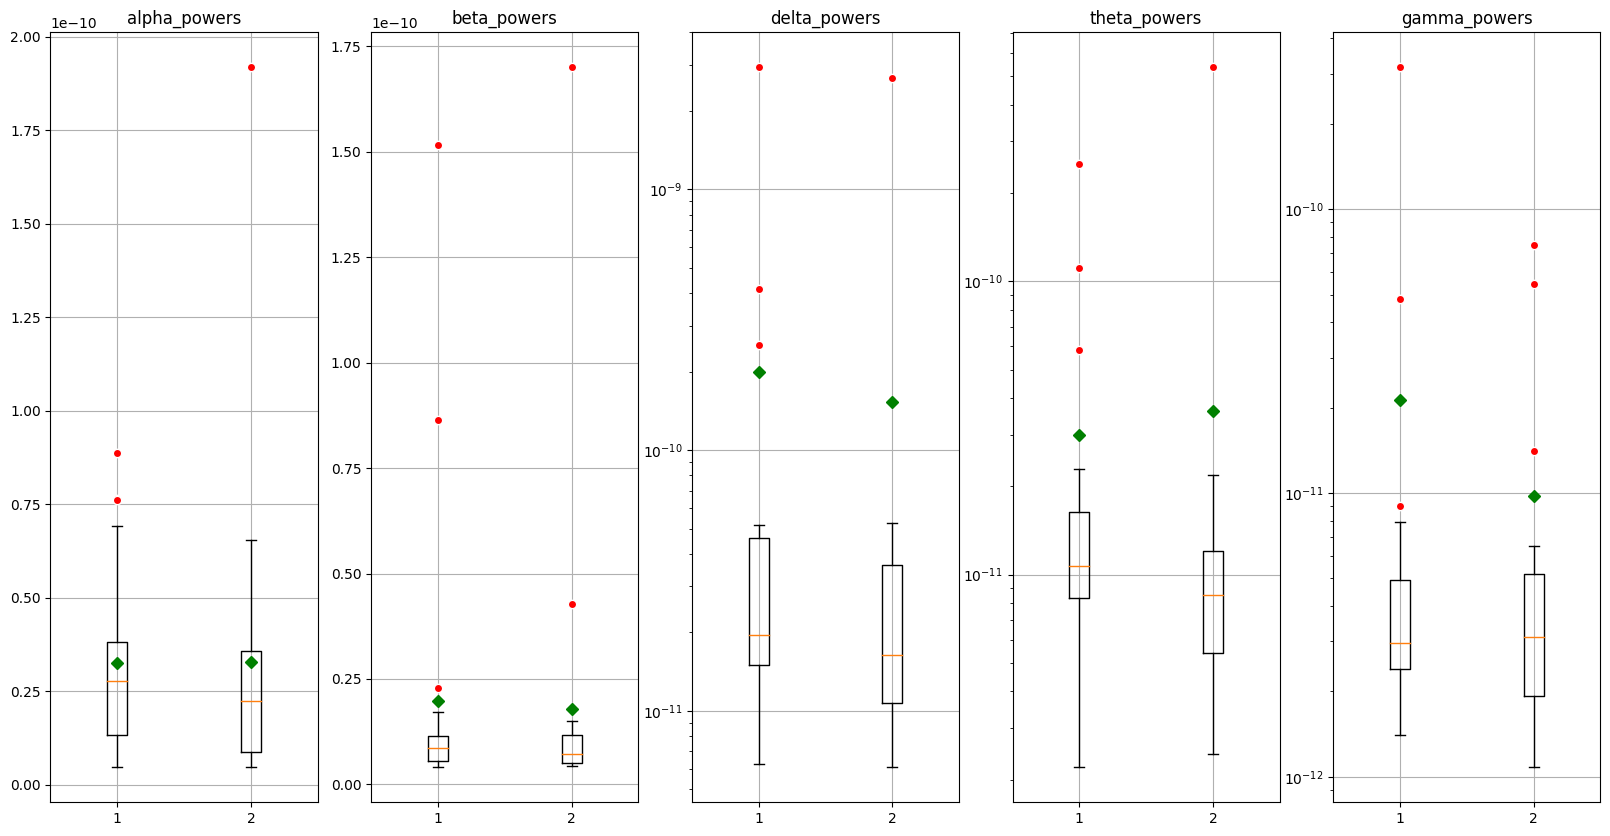

In [9]:
all_powers = [alpha_powers_pre, alpha_powers_post, beta_powers_pre, beta_powers_post, delta_powers_pre, delta_powers_post, theta_powers_pre, theta_powers_post, gamma_powers_pre, gamma_powers_post]

all_powers_labels = ['alpha_powers', 'beta_powers', 'delta_powers', 'theta_powers', 'gamma_powers']

red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')
mean_shape = dict(markerfacecolor='green', marker='D', markeredgecolor='green')

plt.figure(figsize=(20, 10))
plt.subplot(1, 5, 1)
plt.boxplot(all_powers[0: 2], flierprops=red_circle, showmeans=True, meanprops=mean_shape)
plt.title(all_powers_labels[0])
plt.grid()

plt.subplot(1, 5, 2)
plt.boxplot(all_powers[2: 4], flierprops=red_circle, showmeans=True, meanprops=mean_shape)
plt.title(all_powers_labels[1])
plt.grid()

plt.subplot(1, 5, 3)
plt.boxplot(all_powers[4: 6], flierprops=red_circle, showmeans=True, meanprops=mean_shape)
plt.semilogy()
plt.grid()
plt.title(all_powers_labels[2])

plt.subplot(1, 5, 4)
plt.boxplot(all_powers[6: 8], flierprops=red_circle, showmeans=True, meanprops=mean_shape)
plt.title(all_powers_labels[3])
plt.semilogy()
plt.grid()

plt.subplot(1, 5, 5)
plt.boxplot(all_powers[8: 10], flierprops=red_circle, showmeans=True, meanprops=mean_shape)
plt.title(all_powers_labels[4])
plt.semilogy()
plt.grid()
plt.show()

Looking into the relationship between all of the channels instead of combining all channels into one

In [10]:
cols = []
bands = ['alpha', 'beta', 'delta', 'theta', 'gamma']

for i in range(5):
    for j in range(64):
        cols.append(bands[i] + str(j + 1))

cols.append('target')

In [11]:
all_combined_pre = []
all_combined_post = []
all_combined_pre_relative = []
all_combined_post_relative = []

for i in range(20):
    all_combined_pre.append(alpha_powers_pre_all[i] + beta_powers_pre_all[i] + delta_powers_pre_all[i] + theta_powers_pre_all[i] + gamma_powers_pre_all[i] + [1])
    all_combined_post.append(alpha_powers_post_all[i] + beta_powers_post_all[i] + delta_powers_post_all[i] + theta_powers_post_all[i] + gamma_powers_post_all[i] + [0])

    all_combined_pre_relative.append(alpha_relative_pre_all[i] + beta_relative_pre_all[i] + delta_relative_pre_all[i] + theta_relative_pre_all[i] + gamma_relative_pre_all[i] + [1])
    all_combined_post_relative.append(alpha_relative_post_all[i] + beta_relative_post_all[i] + delta_relative_post_all[i] + theta_relative_post_all[i] + gamma_relative_post_all[i] + [0])

In [12]:

all_combined = all_combined_pre + all_combined_post
all_combined_relative = all_combined_pre_relative + all_combined_post_relative
df = pd.DataFrame(all_combined, columns = cols, dtype = float)
df.to_excel('Dataset_window_multitaper.xlsx')
df = pd.DataFrame(all_combined_relative, columns = cols, dtype = float)
df.to_excel('Dataset_window_relative_multitaper.xlsx')

Computing pairwise T plots for all powers

In [13]:
alpha_powers_pre_all_t = np.array(alpha_powers_pre_all).T.tolist()
alpha_powers_post_all_t = np.array(alpha_powers_post_all).T.tolist()
beta_powers_pre_all_t = np.array(beta_powers_pre_all).T.tolist()
beta_powers_post_all_t = np.array(beta_powers_post_all).T.tolist()
delta_powers_pre_all_t = np.array(delta_powers_pre_all).T.tolist()
delta_powers_post_all_t = np.array(delta_powers_post_all).T.tolist()
theta_powers_pre_all_t = np.array(theta_powers_pre_all).T.tolist()
theta_powers_post_all_t = np.array(theta_powers_post_all).T.tolist()
gamma_powers_pre_all_t = np.array(gamma_powers_pre_all).T.tolist()
gamma_powers_post_all_t = np.array(gamma_powers_post_all).T.tolist()

def compute_ttest(pre, post):
    results = []
    for i in range(64):
        results.append(stats.ttest_rel(pre[i], post[i]))
        if(results[i].pvalue <= 0.05):
            print(i + 1)

print("ALPHA")
compute_ttest(alpha_powers_pre_all_t, alpha_powers_post_all_t)
print("BETA")
compute_ttest(beta_powers_pre_all_t, beta_powers_post_all_t)
print("DELTA")
compute_ttest(delta_powers_pre_all_t, delta_powers_post_all_t)
print("THETA")
compute_ttest(theta_powers_pre_all_t, theta_powers_post_all_t)
print("GAMMA")
compute_ttest(gamma_powers_pre_all_t, gamma_powers_post_all_t)

ALPHA
BETA
DELTA
THETA
GAMMA


In [14]:
alpha_relative_pre_all_t = np.array(alpha_relative_pre_all).T.tolist()
alpha_relative_post_all_t = np.array(alpha_relative_post_all).T.tolist()
beta_relative_pre_all_t = np.array(beta_relative_pre_all).T.tolist()
beta_relative_post_all_t = np.array(beta_relative_post_all).T.tolist()
delta_relative_pre_all_t = np.array(delta_relative_pre_all).T.tolist()
delta_relative_post_all_t = np.array(delta_relative_post_all).T.tolist()
theta_relative_pre_all_t = np.array(theta_relative_pre_all).T.tolist()
theta_relative_post_all_t = np.array(theta_relative_post_all).T.tolist()
gamma_relative_pre_all_t = np.array(gamma_relative_pre_all).T.tolist()
gamma_relative_post_all_t = np.array(gamma_relative_post_all).T.tolist()

def compute_ttest(pre, post):
    results = []
    for i in range(64):
        results.append(stats.ttest_rel(pre[i], post[i]))
        if(results[i].pvalue <= 0.05):
            print(i + 1)

print("ALPHA")
compute_ttest(alpha_relative_pre_all_t, alpha_relative_post_all_t)
print("BETA")
compute_ttest(beta_relative_pre_all_t, beta_relative_post_all_t)
print("DELTA")
compute_ttest(delta_relative_pre_all_t, delta_relative_post_all_t)
print("THETA")
compute_ttest(theta_relative_pre_all_t, theta_relative_post_all_t)
print("GAMMA")
compute_ttest(gamma_relative_pre_all_t, gamma_relative_post_all_t)

ALPHA
BETA
18
DELTA
THETA
GAMMA
